<center>
    <h1>
        Image Processing and Computer Vision
    </h1>
    <h2>
        Fruit inspection Project
    </h2>
</center>

Student: Valerio Tiri

Description: Students should develop a software system aimed at locating defects and imperfections on fruits. Each fruit is acquired
through a NIR (Near Infra-Red) and a color camera.

Hi, my name is Valerio, and I'm reporting my project for the Computer Vision and Image Processing exam at the University of Bologna with Prof. Luigi Di Stefano. The project I selected is titled 'Fruit Inspection'. It consists of three subparts, each aimed at exploring different aspects of the theory covered in class.

Normally, Computer Vision applications in industrial field follow a pipeline like:

$$
\text{Image} \rightarrow \text{Filtering} \rightarrow \text{Segmentation} \rightarrow \text{Blob Analisys} \rightarrow \text{Final Info}
$$
Approximately we will see these steps in this work.

# FIRST TASK

1. Outline the fruit by generating a binary mask
2. Search for the defects on each fruit

First of all, let's import the libraries.

In [12]:
# import cv2
import cv2

# import numpy
import numpy as np

# import pyplot
from matplotlib import pyplot as plt

In [13]:
#load the ir images to analyze for the first task
image1_ir = cv2.imread("first_task/C0_000001.png", cv2.IMREAD_GRAYSCALE)
image2_ir = cv2.imread("first_task/C0_000002.png", cv2.IMREAD_GRAYSCALE)
image3_ir = cv2.imread("first_task/C0_000003.png", cv2.IMREAD_GRAYSCALE)

#load the rgb images 
bgr_image1 = cv2.imread("first_task/C1_000001.png")
bgr_image2 = cv2.imread("first_task/C1_000002.png")
bgr_image3 = cv2.imread("first_task/C1_000003.png")
image1_rgb = cv2.cvtColor(bgr_image1,cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(bgr_image2,cv2.COLOR_BGR2RGB)
image3_rgb = cv2.cvtColor(bgr_image3,cv2.COLOR_BGR2RGB)

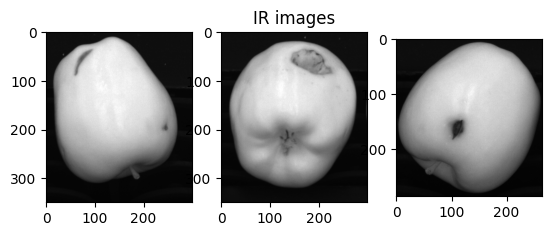

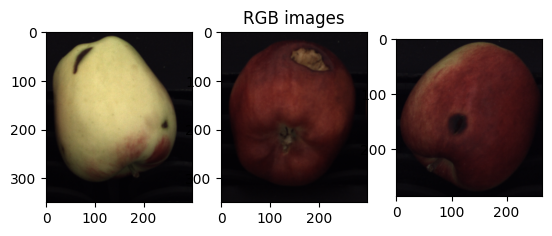

In [14]:
plt.subplot(1,3,1)
plt.imshow(image1_ir,cmap='gray',vmin=0,vmax=255)
plt.subplot(1,3,2)
plt.imshow(image2_ir,cmap='gray',vmin=0,vmax=255)
plt.title("IR images")
plt.subplot(1,3,3)
plt.imshow(image3_ir,cmap='gray',vmin=0,vmax=255)
plt.show()

plt.subplot(1,3,1)
plt.imshow(image1_rgb)
plt.subplot(1,3,2)
plt.imshow(image2_rgb)
plt.title("RGB images")
plt.subplot(1,3,3)
plt.imshow(image3_rgb)
plt.show()

### Our goal is now to extract a mask and overlap it to the original images. 
For having a better result we can filter out the IR images (on which we will compute the mask). In this case the fruit edges are crucial for the defect detection so we need to preserve them. Because of this I used a Bilateral filter. 
The Bilateral Filter is an advanced non-linear filter to accomplish denoising of Gaussian-like noise without blurring the image edges.

The formula of the bilateral filter is:
$$
\text{BF}(I)_{(p)} = \frac{1}{W(q, p)} G_{\sigma_s}(d_s(p, q)) \cdot G_{\sigma_r}(d_r(I_p, I_q))
$$

where:
- \( q \) is the current pixel.
- \( p \) is the central pixel.
- \( G_sigma_s \) is the gaussian function with variance \( sigma_s \), that measures the spacial distance from \( p \) to \( q \).
- \( G_sigma_r \) is the gaussian function with variance \( sigma_r \), that measures the intensity distance from \( I_p \) to \( I_q \).
- \( W_p \) is the normalization.


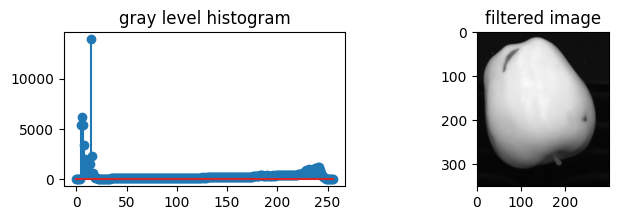

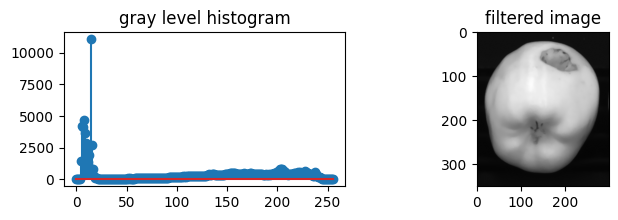

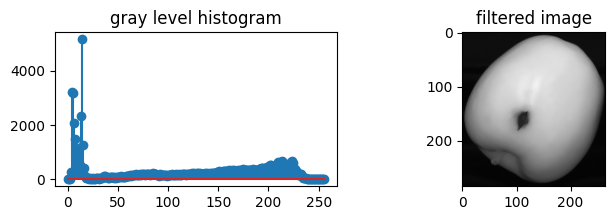

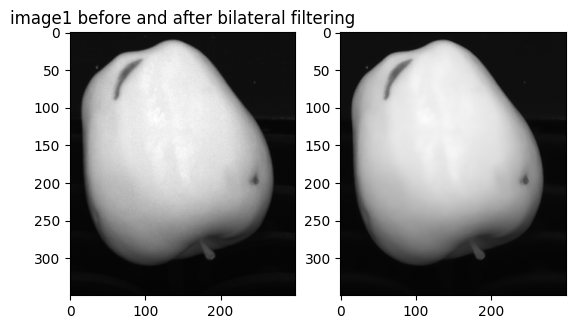

In [15]:
def BilateralFilter(img):
    img_f = np.copy(img)
    # function arguments: image, diameter of the filer, and how much veries the weights 
    # of the pixels based on color and the spatial coordinates
    img_f = cv2.bilateralFilter(img, d = 12, sigmaColor = 10, sigmaSpace = 3)

    # extract and plot the histogram
    hist,bins = np.histogram(img_f.flatten(),256,[0,256])
    plt.figure(figsize=(8, 2))
    plt.subplot(1,2,1)
    plt.title("gray level histogram")
    plt.stem(hist)#, use_line_collection=True)
    plt.subplot(1,2,2)
    plt.imshow(img_f,cmap='gray',vmin=0,vmax=255)
    plt.title("filtered image")
    plt.show()

    return img_f

# call the function
img1_ir_f = BilateralFilter(image1_ir)
img2_ir_f = BilateralFilter(image2_ir)
img3_ir_f = BilateralFilter(image3_ir)

plt.subplot(1,2,1)
plt.imshow(image1_ir,cmap='gray',vmin=0,vmax=255)
plt.title("image1 before and after bilateral filtering")
plt.subplot(1,2,2)
plt.imshow(img1_ir_f,cmap='gray',vmin=0,vmax=255)
plt.show()


Once we have the smoothed the images we can create the mask by applying a threshold, pixels below it becomes black, pixels above it becomes white. This will create a binary mask which we can analyze to understand if the fruit is good or not. The choice of this threshold can be done by hand or by one of the algorithms we have seen at lesson, for example the Otsu's algorithm.

### For this project I made different attempts and some of them are still in the code in order to see the differences and the motivations behind every project choice.

Firstly I tried a fixed threshold selection.

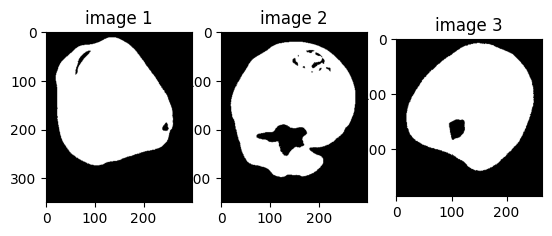

In [16]:
def make_mask(img_grayscale, th):
    # apply threshold
    _, mask = cv2.threshold(img_grayscale, th, 255, cv2.THRESH_BINARY)
    return mask

# threshold choice
thresh = 130

# call the function
img1_mask_t = make_mask(img1_ir_f, thresh)
img2_mask_t = make_mask(img2_ir_f, thresh)
img3_mask_t = make_mask(img3_ir_f, thresh)

plt.subplot(1,3,1)
plt.imshow(img1_mask_t, cmap='gray')
plt.title("image 1")
plt.subplot(1,3,2)
plt.imshow(img2_mask_t, cmap='gray')
plt.title("image 2")
plt.subplot(1,3,3)
plt.imshow(img3_mask_t, cmap='gray')
plt.title("image 3")
plt.show()

Unfortunately not all the real images has the same gray-scale histogram so use a single threshold do not give always good results as we can see in the second image. What we need is an adaptive threshold and the most suitable algorithm is the Otsu. 

The Otsu algorithm finds the optimal threshold by minimizing across the gray-level range the so-called Within-group Variance of the resulting regions, such an indicator measuring how spread turn out region intensities upon binarization by a given gray-level. In fact, the Within-group Variance of the two regions is defined as the weighted sum of their variances. 

In this cell, once we extract the binary mask there are some holes, the defects, that we need to fill for having the mask only of the fruit border.To do that I used the flood fill function.

selected threshold for this image:  109.0


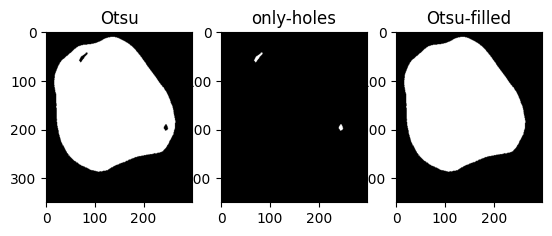

selected threshold for this image:  98.0


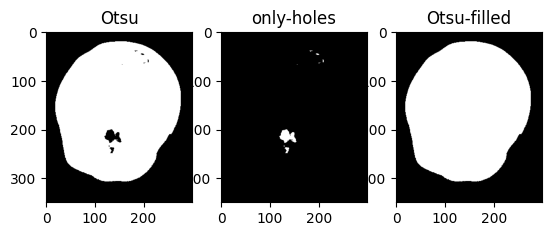

selected threshold for this image:  104.0


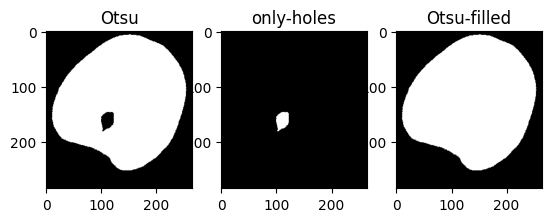

In [17]:
def otsu_ff(img):

    # use otsu to binarize the image using adaptive threshold
    threshold_sel, binary_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    print('selected threshold for this image: ', threshold_sel)

    # create a copy of the mask to fill because imperfections result in black holes
    copy_mask = np.copy(binary_mask)
    cv2.floodFill(copy_mask, None, (0, 0), 255)
    mask_filled = cv2.bitwise_not(copy_mask)

    # do an 'or' between the filled mask and the otsu one
    final_mask = binary_mask | mask_filled

    plt.subplot(1,3,1)
    plt.imshow(binary_mask, cmap='gray',vmin=0,vmax=255)
    plt.title("Otsu")
    plt.subplot(1,3,2)
    plt.imshow(mask_filled, cmap='gray',vmin=0,vmax=255)
    plt.title("only-holes")
    plt.subplot(1,3,3)
    plt.imshow(final_mask, cmap='gray',vmin=0,vmax=255)
    plt.title("Otsu-filled")
    plt.show()
    return final_mask

# call the function
img1_mask = otsu_ff(img1_ir_f)
img2_mask = otsu_ff(img2_ir_f)
img3_mask = otsu_ff(img3_ir_f)

As we can see from the output the selected threshold for every image is not always the same to better adapt to the specific image. Another type of thersholding method that could have been used is the Adapive one, but since the scenes are quite unifomely illuminated I believed that the use of such a method was like over-engineering the solution.

We can use the obtained mask to segment the orginal images to eliminate the background and isolate the fruit.

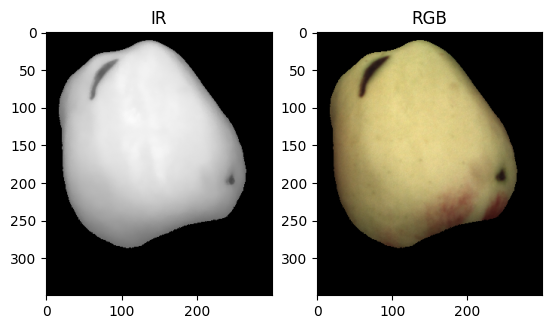

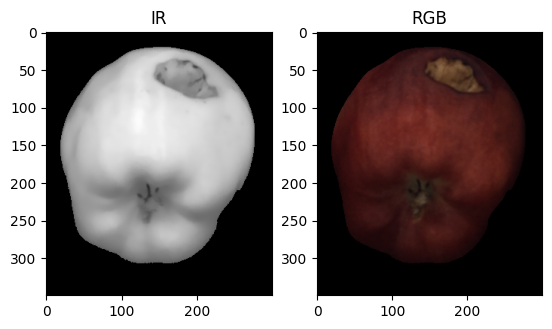

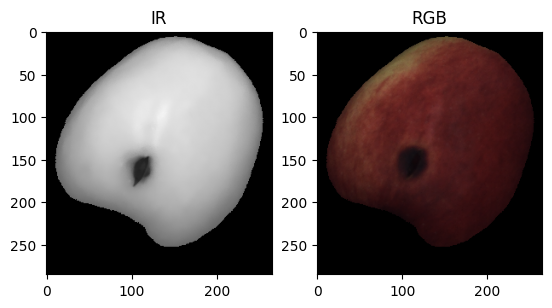

In [18]:
def segment_with_mask(mask, img_ir, img_rgb):
    # we can do the segmentation simply by the use of logical operator
    seg_ir = mask & img_ir
    seg_rgb = img_rgb & cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    plt.subplot(1,2,1)
    plt.imshow(seg_ir, cmap='gray',vmin=0,vmax=255)
    plt.title("IR")
    plt.subplot(1,2,2)
    plt.imshow(seg_rgb)
    plt.title("RGB")
    plt.show()
    return seg_ir, seg_rgb

# call the function
img1_seg_ir, img1_seg_rgb = segment_with_mask(img1_mask, img1_ir_f, image1_rgb)
img2_seg_ir, img2_seg_rgb = segment_with_mask(img2_mask, img2_ir_f, image2_rgb)
img3_seg_ir, img3_seg_rgb = segment_with_mask(img3_mask, img3_ir_f, image3_rgb)

Once we have only the object to analyze we can:
1. detect the area of the defect simply by the use of the flood filled mask we have seen before (that's what have been done for kiwi) overlapping it to the masked image, this is a simpler approach but less reliable.
2. detect the defect edges by the use of an edge detector, this will extract all the edges in the image so we need to discriminate between fruit edges and defect edges.

Now I will use the approach number two. The edge detection is carried out by the Canny's edge detector.
This edge detection operation consists in finding local extrema of the convolution of the signal by a first order Gaussian derivative. In practical is made by Gaussian smoothing followed by gradient computation and NMS along the gradient direction. It comprehend also a “hysteresis” thresholding approach, thanks to which the Canny's edge detector provides as output chains of connected edge pixels rather than edge maps.

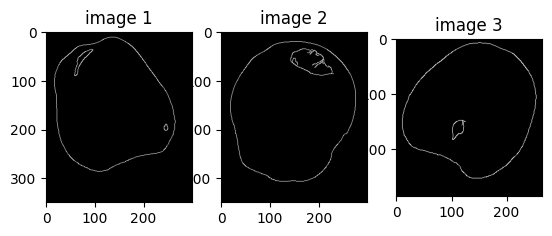

In [19]:
# Canny function parameters: image to analyze, lower Th, higher Th
img1_edge_ir = cv2.Canny(img1_seg_ir, 50, 220)
img2_edge_ir = cv2.Canny(img2_seg_ir, 50, 250)
img3_edge_ir = cv2.Canny(img3_seg_ir, 50, 220)

plt.subplot(1,3,1)
plt.imshow(img1_edge_ir, cmap='gray',vmin=0,vmax=255)
plt.title("image 1")
plt.subplot(1,3,2)
plt.imshow(img2_edge_ir, cmap='gray',vmin=0,vmax=255)
plt.title("image 2")
plt.subplot(1,3,3)
plt.imshow(img3_edge_ir, cmap='gray',vmin=0,vmax=255)
plt.title("image 3")
plt.show()

In the last cell I cheated a bit by not using always the same Th values for the Canny's in all the images (for having better results). In industry this is not possible because the system must be automated and the hysteresys values are hyperparameters.

#### To understand the importance of doing segmentation before the edge detection, we can try to apply the edge detector directly to the filtered, not masked, images. So the ones still with the background.

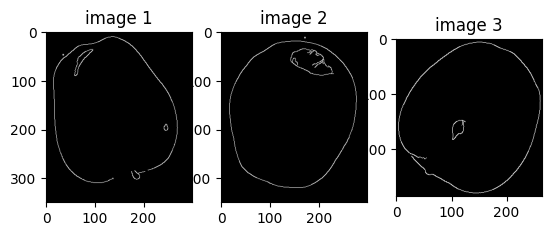

In [20]:
img1_edge_ir_f = cv2.Canny(img1_ir_f, 75, 200)
img2_edge_ir_f = cv2.Canny(img2_ir_f, 50, 250)
img3_edge_ir_f = cv2.Canny(img3_ir_f, 30, 220)

plt.subplot(1,3,1)
plt.imshow(img1_edge_ir_f, cmap='gray',vmin=0,vmax=255)
plt.title("image 1")
plt.subplot(1,3,2)
plt.imshow(img2_edge_ir_f, cmap='gray',vmin=0,vmax=255)
plt.title("image 2")
plt.subplot(1,3,3)
plt.imshow(img3_edge_ir_f, cmap='gray',vmin=0,vmax=255)
plt.title("image 3")
plt.show()

As we can see is worth doing the segmentation for having better edge detection.

Let's have a look to another edge detection we have studied, the Sobel edge detector. The principle of the Sobel is to calculate the gradient on x or y directions by applying the Sobel's kernel, compute the modulus of the gradient, then apply a threshold to identify border pixels. With the Sobel function we can choose between doing the gradient just along one axis or both.

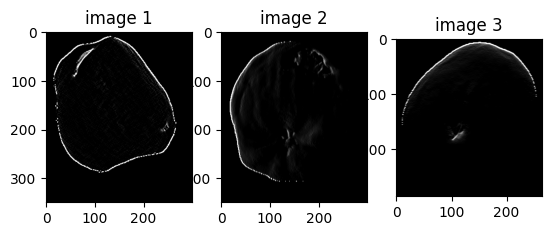

In [21]:
# argument of function: image, depth of output image, order of derivative in directions x and y, kernel size
img1_sobel = cv2.Sobel(src=img1_seg_ir, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
img2_sobel = cv2.Sobel(src=img2_seg_ir, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
img3_sobel = cv2.Sobel(src=img3_seg_ir, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)

plt.subplot(1,3,1)
plt.imshow(img1_sobel, cmap='gray',vmin=0,vmax=255)
plt.title("image 1")
plt.subplot(1,3,2)
plt.imshow(img2_sobel, cmap='gray',vmin=0,vmax=255)
plt.title("image 2")
plt.subplot(1,3,3)
plt.imshow(img3_sobel, cmap='gray',vmin=0,vmax=255)
plt.title("image 3")
plt.show()

The output is not good enough with any configuration to perform defect analisys, in the second and third images we are applying the filter only on the x or y direction.

### Next step is to eliminate the edges of the fruit without touching the edges of the defects. We already have an only-fruit-border detection that is the mask we get before. The idea is to erode a bit the white part of the mask, then overlap it to the only-edge mask with the 'and' operator.
The erosion is done using a kernel, cv2 libraries gives us three different kernel structures: rectangle, cross and ellipse, which gives different output dependig also on how many pixels the kernel is made. In this cell I made an example of the different output from the three kernels.

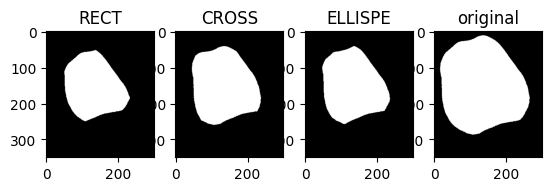

In [22]:
# argument of function: structuring element, kernel size, anchor (point of application)
elem1 = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20),(10, 10))
elem2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20),(10, 10))
elem3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20),(10, 10))

img_er_test_1= cv2.erode(img1_mask, elem1, iterations = 3)
img_er_test_2 = cv2.erode(img1_mask, elem2, iterations = 3)
img_er_test_3 = cv2.erode(img1_mask, elem3, iterations = 3)

# plot
plt.subplot(1,4,1)
plt.imshow(img_er_test_1, cmap='gray')
plt.title("RECT")
plt.subplot(1,4,2)
plt.imshow(img_er_test_2, cmap='gray')
plt.title("CROSS")
plt.subplot(1,4,3)
plt.imshow(img_er_test_3, cmap='gray')
plt.title("ELLISPE")
plt.subplot(1,4,4)
plt.imshow(img1_mask, cmap='gray')
plt.title("original")
plt.show()

Is evident how the output is not the same depending on the kernel.

### For the project implementation I used the rectangle kernel but all of them were suitable because the erosion to do was just to eliminate few pixels. Only one iteration was needed.

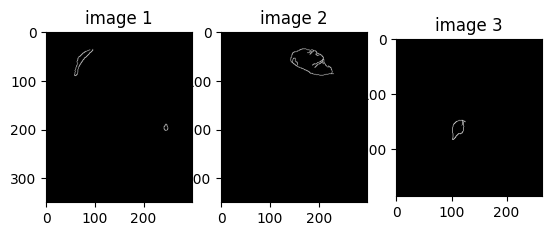

In [23]:
def get_defects(img_mask, img_edge):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20),(0, 0))
    img_eroded = cv2.erode(img_mask, element)
    # 'and' operator between the eroded mask and the border mask
    image_defect = img_eroded & img_edge
    return image_defect

img1_defect = get_defects(img1_mask, img1_edge_ir)
img2_defect = get_defects(img2_mask, img2_edge_ir)
img3_defect = get_defects(img3_mask, img3_edge_ir)

plt.subplot(1,3,1)
plt.imshow(img1_defect, cmap='gray')
plt.title("image 1")
plt.subplot(1,3,2)
plt.imshow(img2_defect, cmap='gray')
plt.title("image 2")
plt.subplot(1,3,3)
plt.imshow(img3_defect, cmap='gray')
plt.title("image 3")
plt.show()

## Only the defects are left into the border mask!
We can simply overlap them with the original images pixels and color them, but there is a problem, the parallax between the two images.

### Parallax can be solved in two ways:
1. Find the difference statically between the two cameras
2. Apply computer vision algorithms to find the homography between the two images.
I tried both these systems, starting from the point two I did the following steps:
1. Finding key point and descriptors in the two images (both in grayscale), with different algorithm like SIFT, ORB and AKAZE
2. Match the descriptors of the two images
3. Filter by distance the good matches
4. Extract the corresponding points
5. Find the Homography matrix (H) and extract the values for the x and y translation from positions [0, 2] and [1, 2] in H, and use them to shift the RGB pixels.

The obtained values from this method were not the expected ones since the algorithm were not able to find enought descriptors to compute fully feasible matches. This may be caused from the instrisic characteristics of the fruits, the smoothness of the colors and the roundness, so the absence of corners, of the fruit make not able the algorithms to find points with enought cornerness to be good descriptors.
Images with descriptors points can be found in the project folder under the names keypoint_*_*.png

Because of this I tried to simply shift the highlighted blue pixels in the RGB images by -3 pixels in both directions. This approach worked well. In this specific industrial case, this approach is the most suitable since the two cameras are in static positions and the translation between them can be easily found experimentally. 

fruit has defect


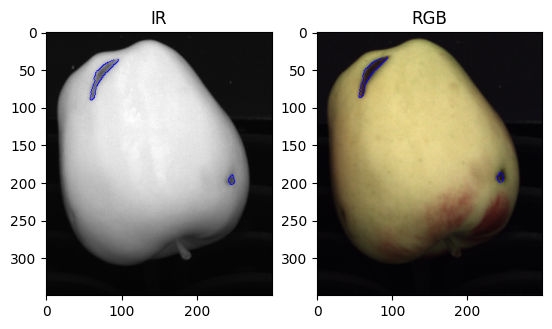

fruit has defect


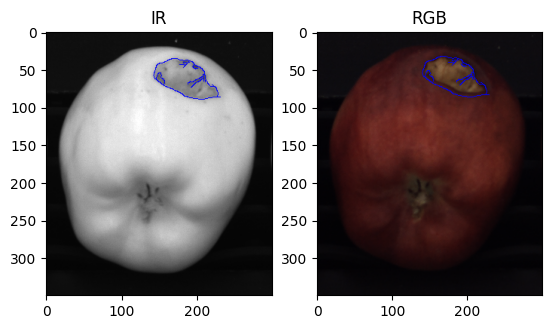

fruit has defect


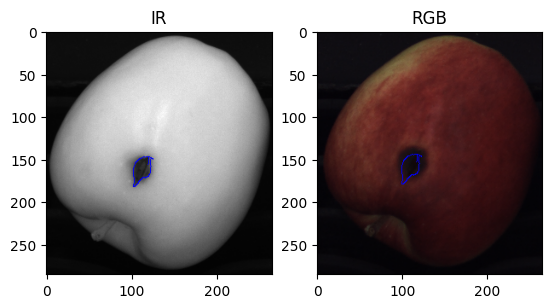

In [24]:
def color_defects(img_rgb, img_ir, def_mask):
    # let the ir image be a depth 3 image like an RGB
    img_ir = cv2.cvtColor(img_ir, cv2.COLOR_GRAY2BGR)

    defect = 0
    #parse raws and colums of images
    for j in range(img_ir.shape[0]):
        for k in range(img_ir.shape[1]):
            
            # if the value of the mask is 1 (TRUE)...
            if(def_mask[j, k]):
                defect = 1
                
                # ...change that pixle into blue in both images
                img_rgb[j-3, k-3] = [0, 0, 255]
                img_ir[j, k] = [0, 0, 255]      
    if defect:
        print('fruit has defect')
    else:
        print('fruit has no defect')
    
    plt.subplot(1,2,1)
    plt.imshow(img_ir, cmap='gray')
    plt.title("IR")
    plt.subplot(1,2,2)
    plt.imshow(img_rgb)
    plt.title("RGB")
    plt.show()

# call the function
color_defects(image1_rgb, image1_ir, img1_defect)
color_defects(image2_rgb, image2_ir, img2_defect)
color_defects(image3_rgb, image3_ir, img3_defect)

# Second task

### Students should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.

First of all let's load the images and apply a bilateral filering to the IR images. This will give us a good base for the binary mask.

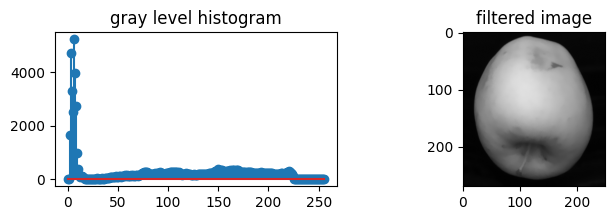

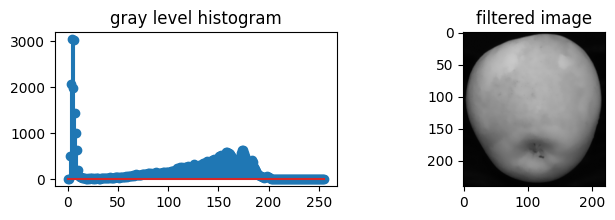

In [25]:
# load the ir images
image4_ir = cv2.imread("second_task/C0_000004.png", cv2.IMREAD_GRAYSCALE)
image5_ir = cv2.imread("second_task/C0_000005.png", cv2.IMREAD_GRAYSCALE)

#load the rgb images 
bgr_image4 = cv2.imread("second_task/C1_000004.png")
bgr_image5 = cv2.imread("second_task/C1_000005.png")
image4_rgb = cv2.cvtColor(bgr_image4,cv2.COLOR_BGR2RGB)
image5_rgb = cv2.cvtColor(bgr_image5,cv2.COLOR_BGR2RGB)

# compute the bilateral filering and extract the gray-level hisogram
img4_ir_f = BilateralFilter(image4_ir)
img5_ir_f = BilateralFilter(image5_ir)


We can now compute the binary mask by the use of a thresholding. From the tests I made, I found out that in this case the use of the Otsu in not necessary since we only need to delete the background without touching at all the friut, so we can choose a custom threshold common for all the images, of a very low value.

After that I added a bit of erosion to eliminate the shadows especially in the first image. Then we can overlap the binary mask to the original images.

selected threshold for this image:  30.0


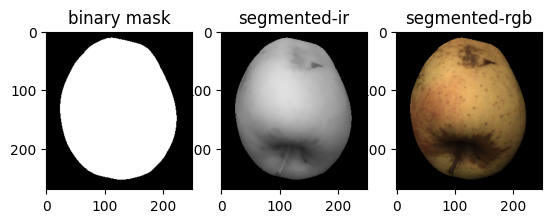

selected threshold for this image:  30.0


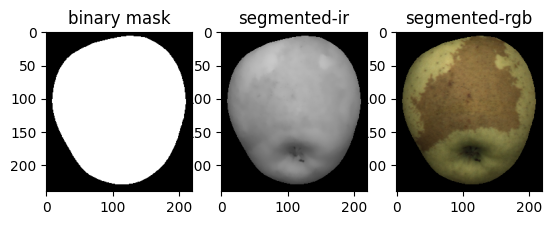

In [26]:
def th_segment(img_ir, img_rgb):
    
    # test with Otsu
    #threshold_sel, binary_mask = cv2.threshold(img_ir, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    threshold_sel, binary_mask = cv2.threshold(img_ir, 30, 255, cv2.THRESH_BINARY)
    print('selected threshold for this image: ', threshold_sel)

    # add some erosion to eliminate shadows, this time using ellipse kernel
    elem3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10),(0, 0))
    binary_mask = cv2.erode(binary_mask, elem3)

    seg_ir = binary_mask & img_ir
    seg_rgb = img_rgb & cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)

    plt.subplot(1,3,1)
    plt.imshow(binary_mask, cmap='gray',vmin=0,vmax=255)
    plt.title("binary mask")
    plt.subplot(1,3,2)
    plt.imshow(seg_ir, cmap='gray',vmin=0,vmax=255)
    plt.title("segmented-ir")
    plt.subplot(1,3,3)
    plt.imshow(seg_rgb)
    plt.title("segmented-rgb")
    plt.show()
    return seg_ir, seg_rgb, binary_mask

img4_seg_ir, img4_seg_rgb, mask4 = th_segment(img4_ir_f, image4_rgb)
img5_seg_ir, img5_seg_rgb, mask5 = th_segment(img5_ir_f, image5_rgb)

### From now on we will deal with color-based segmentation, this type of segmentation consists in classifying as foreground all pixels lying within a 3D sphere of the colour space centred at 𝝁 and having radius as large as T.

To do so we use the Malanobis distance to compute the distance from a pixel color to the reference color we set up. But as we know, the RGB one is not the only color space existing, there are 3 more left: HSV, HLS and LUV. Here we can see an example, we will use them also later.

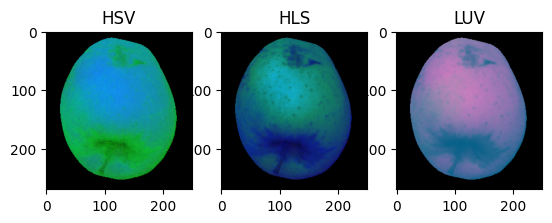

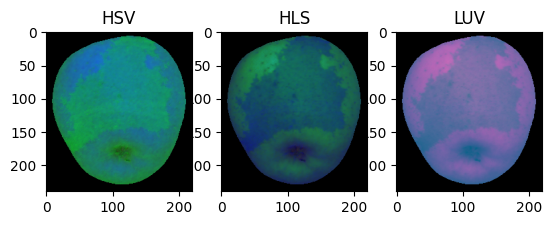

In [27]:
def colorspace(img, mask):
    # HSV (Hue, Saturation, Value)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    seg_hsv = img_hsv & cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    # HLS (Hue, Lightness, Saturation)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    seg_hls = img_hls & cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    # LUV (Luminance, u, v)
    img_luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    seg_luv = img_luv & cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    plt.subplot(1,3,1)
    plt.imshow(seg_hsv)
    plt.title("HSV")
    plt.subplot(1,3,2)
    plt.imshow(seg_hls)
    plt.title("HLS")
    plt.subplot(1,3,3)
    plt.imshow(seg_luv)
    plt.title("LUV")
    plt.show()
    return seg_hsv, seg_hls, seg_luv

img4_seg_hsv, img4_seg_hls, img4_seg_luv = colorspace(image4_rgb, mask4)
img5_seg_hsv, img5_seg_hls, img5_seg_luv = colorspace(image5_rgb, mask5)


### The last step is the more complicated, detect the Russet areas. 
The Malanobis distance is defined as follows:
$$
d(\boldsymbol{I}(p), \boldsymbol{\mu}) = ((\boldsymbol{I}(p) - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{I}(p) - \boldsymbol{\mu}))^{1/2}
$$
where the covariance matrix $\Sigma$ is: 
$$
\Sigma =
\begin{bmatrix}
\sigma^2_{00} & \sigma^2_{01} & \sigma^2_{02} \\
\sigma^2_{10} & \sigma^2_{11} & \sigma^2_{12} \\
\sigma^2_{20} & \sigma^2_{21} & \sigma^2_{22}
\end{bmatrix},
\quad
\sigma^2_{i, j} = \frac{1}{N} \sum_{k = 1}^N (I_i(p) - \mu_i) (I_j(p) - \mu_j)
$$

1. First of all we have to find the center (𝝁) in the color space. We can do this by selecting by hand a Region Of Interest (ROI) and compute the mean on all the pixel within the region.
2. Make a copy of the reference image and rashape it, the result will be a matrix where the raws are the pixels and the colums are the three channels.
3. Compute the inverse of the covariance matrix $\Sigma$ as required by the formula.
4. Compute the Malanobis distance between the image pixels and the mean and append it in a vector.
5. Calculate the mean of the Malanobis distance, we will use this value as threshold to discriminate Russet areas.
6. Reshape the vector with the Malanobis distances for having a 2D matrix where every value is the Malanobis distance of the pixel in the corresponding position in the original image.
7. Parse the image pixels and compare if they are part of the black area of the mask; if they are not, compare the Malanobis distance of that pixel with the mean, if it is minor or equal to the mean divided by 1.5 print it yellow in the original image.

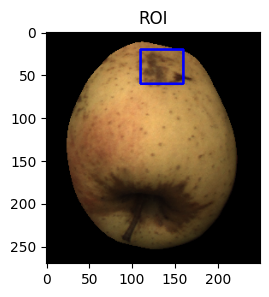

pixel mean is =  [111.416   71.526   39.2845]
covariance matrix =  [[ 0.01979851 -0.02027402 -0.01063417]
 [-0.02027402  0.08125725 -0.09661459]
 [-0.01063417 -0.09661459  0.19763105]]
malanobis mean =  2.6417845595112337
vector rehape =  (270, 250)


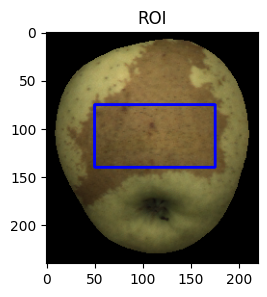

pixel mean is =  [121.09981538 100.54412308  56.81390769]
covariance matrix =  [[ 0.0139779  -0.01607732  0.00072991]
 [-0.01607732  0.07938937 -0.10688703]
 [ 0.00072991 -0.10688703  0.18585048]]
malanobis mean =  1.8989278949236905
vector rehape =  (240, 220)


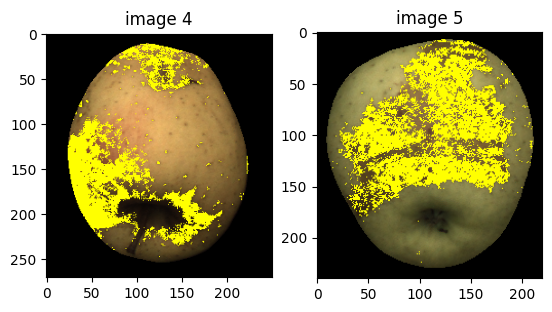

In [28]:
def malanobis_th(vertex1, vertex2, img, mask):

    img_c = np.copy(img)
    # print the rectangle of ROI
    img_c = cv2.rectangle(img_c, vertex1, vertex2, (0, 0, 255), 2)
    plt.figure(figsize=(3, 3))
    plt.imshow(img_c)
    plt.title("ROI")
    plt.show()

    # calculate the mean value of the pixels inside the ROI 
    pixel_mean = np.mean(img[vertex1[0]:vertex2[0], vertex1[1]:vertex2[1]], axis = (0,1))
    print('pixel mean is = ', pixel_mean)

    img_mal = np.copy(img)
    img_col = np.copy(img)
    # flattening the image mean that every raw of the matrix represents a pixel
    # the 3 colums are the color channels
    img_mal = img_mal.reshape(img.shape[0] * img.shape[1], img.shape[2])

    # compute the inverse of covariance matrix 
    covariance_mat = np.linalg.inv(np.cov(img_mal.T))
    print('covariance matrix = ', covariance_mat)

    # define a vector in which append the values
    malanobis_value = []
    for k in img_mal:
        # calcualte the Malanobis distance for every pixel
        malanobis_value.append(np.sqrt(np.dot(np.dot((k - pixel_mean).T, covariance_mat), (k - pixel_mean))))
    
    # calculate the mean of the Malanobis, we will use it as threshold to discriminate russet areas
    malanobis_mean = np.mean(malanobis_value)
    print('malanobis mean = ', malanobis_mean)
    
    # reshape the Malanobis array, in this way we have a 2D map of the Malanobis of the pixels
    # thank to this we can compare them with the pixel values
    malanobis_value = np.array(malanobis_value).reshape(img.shape[0], img.shape[1])
    print('vector rehape = ', malanobis_value.shape)

    # compare the Malanobis distances of the image with the mean Malanobis value
    # which works as threshold
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            # check if the pixel should be black because of the mask
            # and if it above or below the Malanobis mean
            if mask[i][j] == 255:
                if malanobis_value[i][j] <= malanobis_mean/1.5:
                    # change color on the original image
                    img_col[i,j] = [255, 255, 0]
    return img_col

# verteces of the ROI
v4_up = [110, 20]
v4_down = [160, 60]
v5_up = [50, 75]
v5_down = [175, 140]

# if we want to change the color space we only need to specify 
# the image into the funcion call simply by changing the last part
# of the image name passed as _hsc, _hls, _luv.
russet4 = malanobis_th(v4_up, v4_down, img4_seg_rgb, mask4)
russet5 = malanobis_th(v5_up, v5_down, img5_seg_rgb, mask5)

# examples
#russet4 = malanobis_th(v4_up, v4_down, img4_seg_hsv, mask4)
#russet5 = malanobis_th(v5_up, v5_down, img5_seg_hls, mask5)

plt.subplot(1,2,1)
plt.imshow(russet4)
plt.title("image 4")
plt.subplot(1,2,2)
plt.imshow(russet5)
plt.title("image 5")
plt.show()

After several attempts I found out that the best results are achieved with the RGB color space. Unfortunately there are still some false positive detections, especially in the first image that I was not able to exclude in any way.

# Final challenge
### Students should segment the fruits and locate the defect in image “000007”. Special care should be taken to remove as “background” the dirt on the conveyor as well as the sticker in image “000006”.

First of all let's load the images and apply a bilateral filering to the IR images. This will give us a good base for the binary mask.

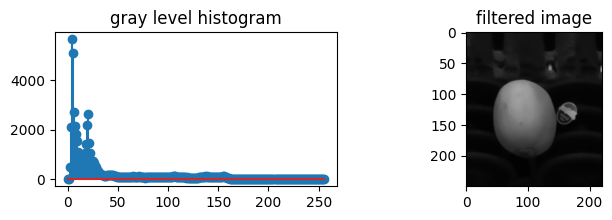

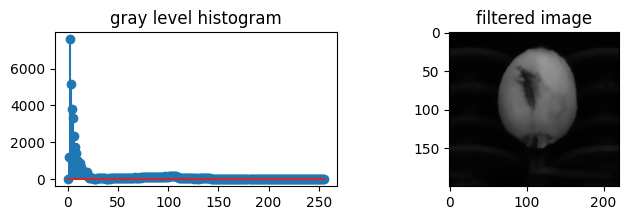

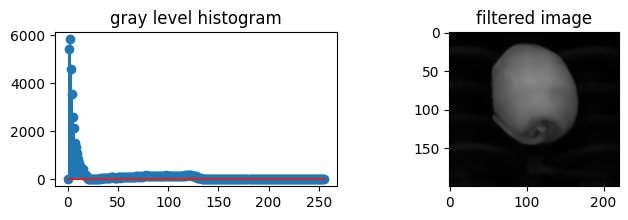

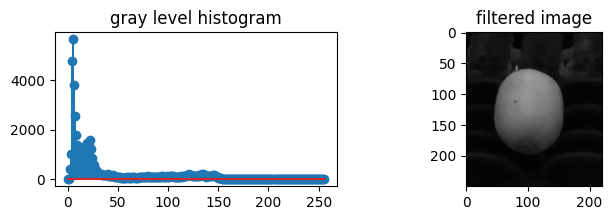

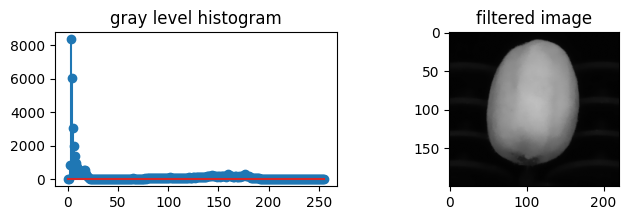

In [29]:
# import the images from the folder
kiwi1_ir = cv2.imread("final_challenge/C0_000006.png", cv2.IMREAD_GRAYSCALE)
kiwi2_ir = cv2.imread("final_challenge/C0_000007.png", cv2.IMREAD_GRAYSCALE)
kiwi3_ir = cv2.imread("final_challenge/C0_000008.png", cv2.IMREAD_GRAYSCALE)
kiwi4_ir = cv2.imread("final_challenge/C0_000009.png", cv2.IMREAD_GRAYSCALE)
kiwi5_ir = cv2.imread("final_challenge/C0_000010.png", cv2.IMREAD_GRAYSCALE)

kiwi1_rb = cv2.imread("final_challenge/C1_000006.png")
kiwi2_rb = cv2.imread("final_challenge/C1_000007.png")
kiwi3_rb = cv2.imread("final_challenge/C1_000008.png")
kiwi4_rb = cv2.imread("final_challenge/C1_000009.png")
kiwi5_rb = cv2.imread("final_challenge/C1_000010.png")

kiwi1_rgb = cv2.cvtColor(kiwi1_rb,cv2.COLOR_BGR2RGB)
kiwi2_rgb = cv2.cvtColor(kiwi2_rb,cv2.COLOR_BGR2RGB)
kiwi3_rgb = cv2.cvtColor(kiwi3_rb,cv2.COLOR_BGR2RGB)
kiwi4_rgb = cv2.cvtColor(kiwi4_rb,cv2.COLOR_BGR2RGB)
kiwi5_rgb = cv2.cvtColor(kiwi5_rb,cv2.COLOR_BGR2RGB)

# filter using the already-seen function
kiwi1_ir_f = BilateralFilter(kiwi1_ir)
kiwi2_ir_f = BilateralFilter(kiwi2_ir)
kiwi3_ir_f = BilateralFilter(kiwi3_ir)
kiwi4_ir_f = BilateralFilter(kiwi4_ir)
kiwi5_ir_f = BilateralFilter(kiwi5_ir)



Our goal is now to isolate the kiwi excluding the imperfections creting a binary mask, in this case I preferred a fixed thresholding method. Also an adaptive one like the Otsu's is suitable for this task.

selected threshold for this image:  60.0
selected threshold for this image:  60.0
selected threshold for this image:  60.0
selected threshold for this image:  60.0
selected threshold for this image:  60.0


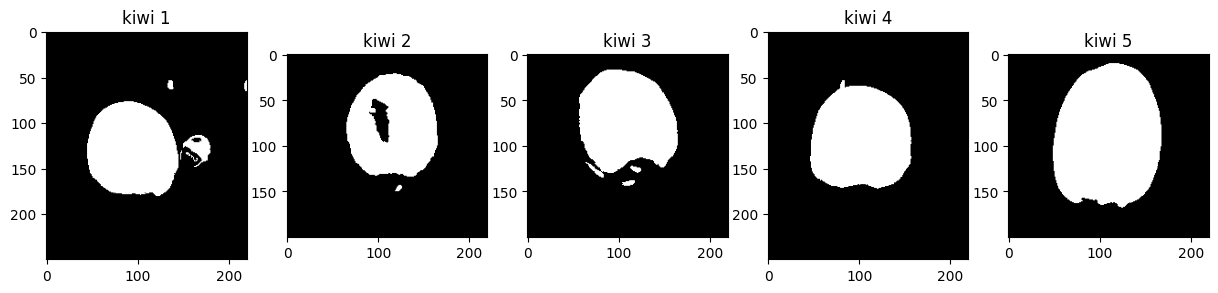

In [30]:
def mask_kiwi(img):

    #threshold_sel, binary_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    threshold_sel, binary_mask = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    print('selected threshold for this image: ', threshold_sel)
    return binary_mask

# call the function
kiwi1_mask = mask_kiwi(kiwi1_ir_f)
kiwi2_mask = mask_kiwi(kiwi2_ir_f)
kiwi3_mask = mask_kiwi(kiwi3_ir_f)
kiwi4_mask = mask_kiwi(kiwi4_ir_f)
kiwi5_mask = mask_kiwi(kiwi5_ir_f)

plt.figure(figsize=(15, 10))
plt.subplot(1,5,1)
plt.imshow(kiwi1_mask, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 1")
plt.subplot(1,5,2)
plt.imshow(kiwi2_mask, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 2")
plt.subplot(1,5,3)
plt.imshow(kiwi3_mask, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 3")
plt.subplot(1,5,4)
plt.imshow(kiwi4_mask, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 4")
plt.subplot(1,5,5)
plt.imshow(kiwi5_mask, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 5")
plt.show()

### Unfortunately we were not able to eliminate all the background dust and the sticker from the image simply by the use of the thresholding.

Because of this we need to perform further manipulations to the masks, but we still need to maintain the kiwi structure intact. To do that we can use dilation and erosion.

### The idea is to erode the mask whit a small kernel but several interation, this aims to eliminate the distractors, so only the kiwi mask will remain even if smaller. Then dilate with the same structuring element (small kernel, multiple iteration) to recover the full kiwi shape.

Once we extract the mask we can can flood fill the black outern area and then invert the pixels, like explained during the first task. In this way we end up with a mask containing only the defects (in white).

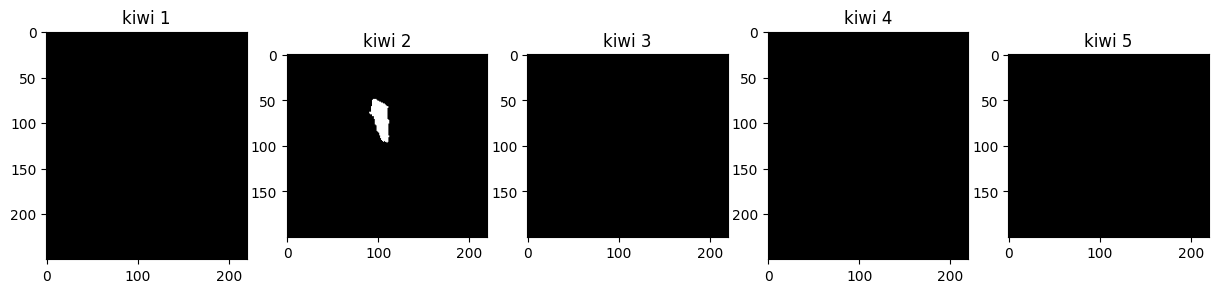

In [31]:
def mask_mod(mask):

    # erosion
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_er = cv2.erode(mask, erosion_kernel, iterations = 4)

    # dilation
    dilating_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_dil = cv2.dilate(mask_er, dilating_kernel, iterations = 4)

    copy_mask = np.copy(mask_dil)
    # apply flood fill like in the first task to isolate the defect
    cv2.floodFill(copy_mask, None, (0, 0), 255)
    defect_mask = cv2.bitwise_not(copy_mask)

    return mask_dil, defect_mask

_ ,kiwi1_mod = mask_mod(kiwi1_mask)
_ ,kiwi2_mod = mask_mod(kiwi2_mask)
_ ,kiwi3_mod = mask_mod(kiwi3_mask)
_ ,kiwi4_mod = mask_mod(kiwi4_mask)
_ ,kiwi5_mod = mask_mod(kiwi5_mask)

plt.figure(figsize=(15, 10))
plt.subplot(1,5,1)
plt.imshow(kiwi1_mod, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 1")
plt.subplot(1,5,2)
plt.imshow(kiwi2_mod, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 2")
plt.subplot(1,5,3)
plt.imshow(kiwi3_mod, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 3")
plt.subplot(1,5,4)
plt.imshow(kiwi4_mod, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 4")
plt.subplot(1,5,5)
plt.imshow(kiwi5_mod, cmap='gray',vmin=0,vmax=255)
plt.title("kiwi 5")
plt.show()


### We can finally overlap the mask to the original image and color in blue the defects.

fruit has no defect


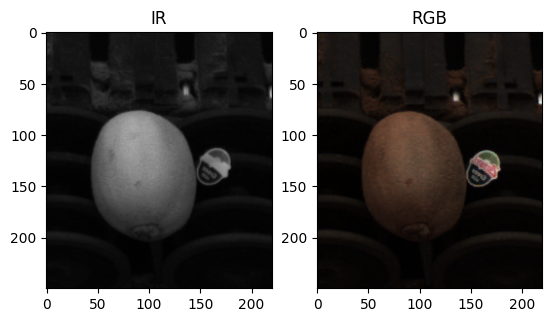

fruit has defect


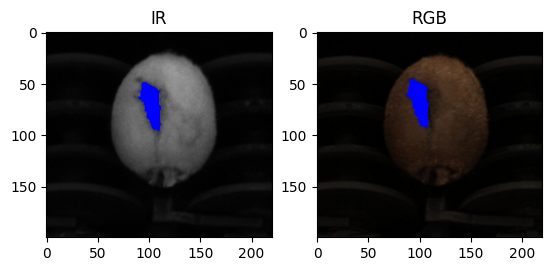

fruit has no defect


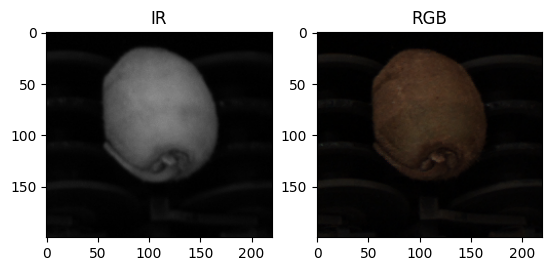

fruit has no defect


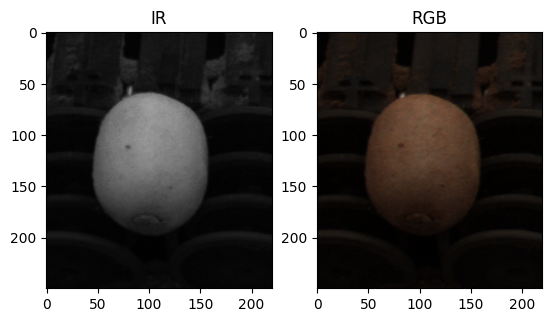

fruit has no defect


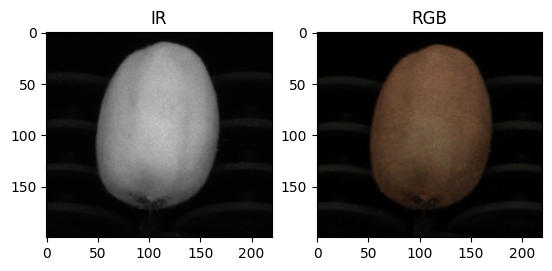

In [32]:
color_defects(kiwi1_rgb, kiwi1_ir, kiwi1_mod)
color_defects(kiwi2_rgb, kiwi2_ir, kiwi2_mod)
color_defects(kiwi3_rgb, kiwi3_ir, kiwi3_mod)
color_defects(kiwi4_rgb, kiwi4_ir, kiwi4_mod)
color_defects(kiwi5_rgb, kiwi5_ir, kiwi5_mod)

### Thank you for your attention!

<center>
    <h2>
        Valerio Tiri, MUNER - EEIV/ADE student
    </h2>
    <h2>
        Soliera (Mo), 14/03/2024
    </h2>
</center>